# Определение возраста покупателей

Описание задачи

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.


Цель работы: разработать нейронную сеть, которая поможет определять возраст клиентов.

Этапы работы:

Знакомство с данными (загрузка)

Анализ данных

Построение нейросети

Выводы

## Исследовательский анализ данных

Загрузка библиотек.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from scipy.stats import norm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Отключение warning
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
pd.options.display.max_columns = None

Загрузка данных.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe()

,real_age
count,"7,591.00"
mean,31.20
std,17.15
min,1.00
25%,20.00
50%,29.00
75%,41.00
max,100.00


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
len(labels['real_age'].unique())

97

Найдем отсутствующие возраста.

In [8]:
ages = np.sort(labels['real_age'].unique())
not_in_ages =[]
for i in range(100):
    if (i+1) not in ages:
        not_in_ages.append(i+1)
print('В датасете отсутствуют фотографии людей возрастов:', not_in_ages) 

В датасете отсутствуют фотографии людей возрастов: [92, 98, 99]


Посмотрим на распределение данных по возрастам.

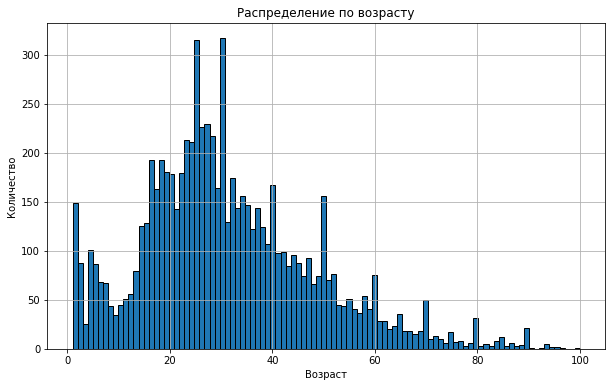

In [9]:
plt.figure(figsize=(10,6))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True);

Рассмотрен датасет с фотографиями людей и их возрастом. Датасет содержит 7591 изображение, возраст людей в диапазоне от 1 до 100 лет.В датасете отсутствуют фотографии людей трех возрастов, что является некритичным. Из гистограммы распределения по возрасту видно, что присутствуют выбросы, соответствующие 1, 25, 30, 40, 50, 60, 70, 80 и 90 годам. Скорее всего, для части фотографий возраст был указан приблизительно. К сожалению, из-за отсутствия других признаков, у нас нет возможности уточнить или удалить неточные данные. Распределение возрастов близко к нормальному со смещением вправо, медианый возраст - 29 лет, средний - 31,2, большая часть людей находится в возрасте от 21 до 40 лет.

## Анализ фотографий

Посмотрим на 10 последних фотографий:

In [10]:
labels_probe = labels.tail(10)
labels_probe

,file_name,real_age
7581,007603.jpg,29
7582,007604.jpg,24
7583,007605.jpg,5
7584,007606.jpg,27
7585,007607.jpg,10
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [11]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow_probe = datagen.flow_from_dataframe(
        dataframe=labels_probe,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 10 validated image filenames.


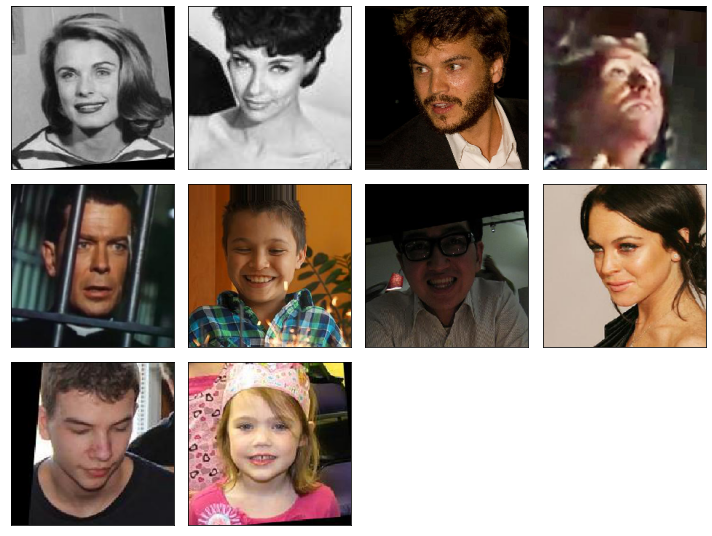

In [12]:
features, target = next(gen_flow_probe)

fig = plt.figure(figsize=(10,10))
for i in range(len(labels_probe)):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Из анализа фотографий можно сделать выводы:

Фотографии цветные, в разных ракурсах, часть из них повернута с целью добиться вертикальности положения головы;

На снимках могут присутствовать предметы, закрывающие часть лица, головные уборы;

Фотографии сделаны при разном по интенсивности, направленности и цветовой температуре освещения.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import (
    GlobalAveragePooling2D, 
    Dense)
    
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        horizontal_flip=True, 
        rescale=1./255)
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255)
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    resnet = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.00025)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model
   
def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/6
356/356 - 54s - loss: 184.7155 - mae: 10.0440 - val_loss: 363.7315 - val_mae: 14.2110
Epoch 2/6
356/356 - 45s - loss: 100.9219 - mae: 7.6323 - val_loss: 167.0611 - val_mae: 10.0650
Epoch 3/6
356/356 - 45s - loss: 78.4612 - mae: 6.7764 - val_loss: 98.5533 - val_mae: 7.6378
Epoch 4/6
356/356 - 47s - loss: 62.7741 - mae: 6.0311 - val_loss: 108.6972 - val_mae: 7.5563
Epoch 5/6
356/356 - 46s - loss: 51.5523 - mae: 5.4688 - val_loss: 104.3468 - val_mae: 7.5527
Epoch 6/6
356/356 - 46s - loss: 41.1136 - mae: 4.9605 - val_loss: 87.5588 - val_mae: 7.1575

119/119 - 11s - loss: 87.5588 - mae: 7.1575
Test MAE: 7.1575
```

## Анализ обученной модели

Рассмотрен датасет с фотографиями людей и их возрастом. Датасет содержит 7591 изображение, возраст людей в диапазоне от 1 до 100 лет.В датасете отсутствуют фотографии людей трех возрастов, что является некритичным. Из гистограммы распределения по возрасту видно, что присутствуют выбросы, соответствующие 1, 25, 30, 40, 50, 60, 70, 80 и 90 годам. Скорее всего, для части фотографий возраст был указан приблизительно. К сожалению, из-за отсутствия других признаков, у нас нет возможности уточнить или удалить неточные данные. Распределение возрастов близко к нормальному со смещением вправо, медианый возраст - 29 лет, средний - 31,2, большая часть людей находится в возрасте от 21 до 40 лет.

Из анализа фотографий можно сделать выводы:

Фотографии цветные, в разных ракурсах, часть из них повернута с целью добиться вертикальности положения головы;

На снимках могут присутствовать предметы, закрывающие часть лица, головные уборы;

Фотографии сделаны при разном по интенсивности, направленности и цветовой температуре освещения

Разработана и обучена модель нейронной сети для определения возраста покупателей. В нейросети применена архитектура ResNet50, предобученная на датасете ImageNet. Был использован слой GlobalAveragePooling2D а также полносвязный слой с одним выходом и функцией активации relu. Размер батча - 16 изображений. Обучение проводилось на 6 эпохах.

По результатам обучения можно сделать следующие выводы:

Время обучения модели - меньше 7 минут;

Модель незначительно переобучена, что характерно для нейронных сетей с большим числом слоёв;

Погрешность меньше 5 лет на обучающей и меньше 7 лет на валидационной выборке можно считать небольшой с учётом небольшого набора данных и возможных неточных данных по возрасту;

При необходимости данные модели можно улучшить путем увеличения обучающего набора данных, более точных данных по возрастам, увелечения количества эпох и подбора шага оптимайзера.

Увеличение числа эпох до 20 также приводит к снижению погешности до 6.5 лет, при этом вермя обучения увеличивается до 20 минут.